In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn 40, 912

#### SET DING0 SETTINGS

In [3]:
# TODO set in config file
ding0_default=False

engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()
create_lvgd_geo_method='convex_hull' # off, convex_hull

In [4]:
%%time

# STEP 1
nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts,
                            ding0_default=ding0_default, need_parameterization=True,
                            create_lvgd_geo_method=create_lvgd_geo_method)

Found connected graph, iteration 0 of max. 4.
Simplified graph: 3 to 2 nodes, 4 to 2 edges
all clusters are in range
=====> MV Grid Districts imported


Wall time: 2.86 s


In [5]:
# STEP 2
# nd.import_generators(session, debug=False)

In [6]:
%%time

# STEP 3
nd.mv_parametrize_grid(debug=False)

Wall time: 8.99 ms


In [7]:
# STEP 4: Validate MV Grid Districts
msg = nd.validate_grid_districts()

In [8]:
%%time

# STEP 5: Build LV grids
nd.build_lv_grids()

LV grid building for la lv_load_area_2128
LVGD building for lv_grid_district_2128000000


Wall time: 77 ms


In [9]:
# STEP 6: Build MV grids
nd.mv_routing(debug=False)

Geo distance is zero, check objects' positions. Distance is set to 1m
Geo distance is zero, check objects' positions. Distance is set to 1m


In [10]:
# STEP 7: Connect MV and LV generators
nd.connect_generators(debug=False)

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

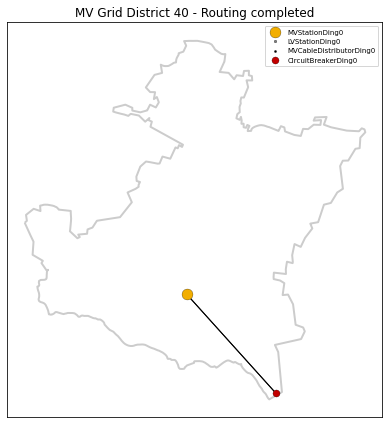

In [11]:
# no aggregated la
grid = nd._mv_grid_districts[0].mv_grid
plot_mv_topology(grid, subtitle='Routing completed', filename=None)

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

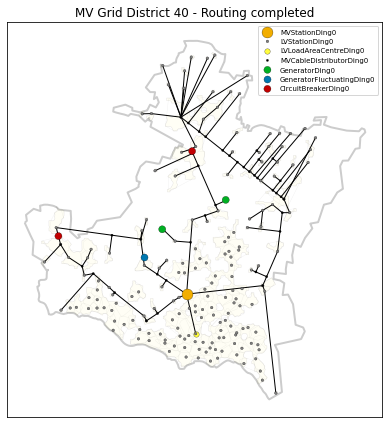

In [11]:
# with aggregated la
grid = nd._mv_grid_districts[0].mv_grid
plot_mv_topology(grid, subtitle='Routing completed', filename=None)

In [12]:
# STEP 8: Relocate switch disconnectors in MV grid
nd.set_circuit_breakers(debug=False)

In [13]:
# STEP 9: Open all switch disconnectors in MV grid
nd.control_circuit_breakers(mode='open')

In [14]:
# check if there are isolated nodes or lv grids may be not connected in one graph
import networkx as nx
stop = False
for la in nd._mv_grid_districts[0]._lv_load_areas:
    for lvgd in la._lv_grid_districts:
        if len(lvgd.lv_grid.graph_isolated_nodes()):
            print('\n' + str(lvgd) + ' has isl\n', lvgd.lv_grid.graph_isolated_nodes())
        g = list(nx.connected_components(lvgd.lv_grid._graph))
        if len(g) > 1:
            print(str(lvgd) + 'has multiple connected components')
            # stop = True
            # break
    if stop:
        break

In [15]:
# check for connected components in graph and isolated nodes
g = list(nx.connected_components(nd._mv_grid_districts[0].mv_grid._graph))
nd._mv_grid_districts[0].mv_grid.graph_isolated_nodes(), len(g)

([circuit_breaker_1], 2)

In [16]:
from ding0.tools.pypsa_io import initialize_component_dataframes, fill_mvgd_component_dataframes, data_integrity, create_powerflow_problem, transform_timeseries4pypsa, import_series_from_dataframe, _check_integrity_of_pypsa
from pandas import date_range
from datetime import datetime


In [17]:
%%time

for grid_district in nd.mv_grid_districts():
    print('\n ITERATION STARTING')
    buses_df, generators_df, lines_df, loads_df, transformer_df = initialize_component_dataframes()
    components, _, components_data = fill_mvgd_component_dataframes(grid_district.mv_grid.grid_district, buses_df, generators_df,
                                                                            lines_df, loads_df, transformer_df,
                                                                            only_export_mv=False,
                                                                            return_time_varying_data=True)
    print('\n ITERATION DONE')


GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes
GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts
STARTING TO EXPORT LV
STARTING TO EXPORT LVLA lv_load_area_2128
STARTING TO EXPORT LVGD lv_grid_district_2128000000. Going to fill_component_dataframes.
GET NODES
GET EDGES
GET TRAFOS
GOING TO nodes_to_dict_of_dataframes



 ITERATION STARTING


GOING TO edges_to_dict_of_dataframes
GOING TO merge_two_dicts



 ITERATION DONE
Wall time: 334 ms


In [18]:
data_integrity(components, components_data)

Bus data is invalid. You supplied 12 Bus objects and 13 datasets. Check you grid data and try again
NoneType: None


SystemExit: 1

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
# choose temp_id
timesteps = 2
start_time = datetime(1970, 1, 1, 00, 00, 0)
resolution = 'H'

# define investigated time range
timerange = date_range(freq=resolution,
                       periods=timesteps,
                       start=start_time)
network, snapshots = create_powerflow_problem(timerange, components)


In [20]:
# import pq-sets
for key in ['Load', 'Generator']:
    for attr in ['p_set', 'q_set']:
        # catch MV grid districts without generators
        if not components_data[key].empty:
            series = transform_timeseries4pypsa(components_data[key][
                                                    attr].to_frame(),
                                                timerange,
                                                column=attr)
            import_series_from_dataframe(network,
                                         series,
                                         key,
                                         attr)

C:\Users\johnr\anaconda3\envs\ding0_env\lib\site-packages\pypsa\io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))


In [21]:
series = transform_timeseries4pypsa(components_data['Bus']
                                    ['v_mag_pu_set'].to_frame(),
                                    timerange,
                                    column='v_mag_pu_set')

import_series_from_dataframe(network,
                             series,
                             'Bus',
                             'v_mag_pu_set')

In [22]:
_check_integrity_of_pypsa(network)

In [23]:
network.lpf()
network.pf(use_seed=True)


INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 01:00:00'], dtype='datetime64[ns]', freq='H')
INFO:pypsa.pf:Newton-Raphson solved in 2 iterations with error of 0.000000 in 0.028984 seconds
INFO:pypsa.pf:Newton-Raphson solved in 0 iterations with error of 0.000000 in 0.002996 seconds


{'n_iter':                      0
 1970-01-01 00:00:00  2
 1970-01-01 01:00:00  0,
 'error':                                 0
 1970-01-01 00:00:00  7.647544e-09
 1970-01-01 01:00:00  2.220446e-15,
 'converged':                         0
 1970-01-01 00:00:00  True
 1970-01-01 01:00:00  True}

In [24]:
print(f"Line: there is na is {components['Line'][['length', 'bus0', 'bus1', 's_nom', 'type_info']].isnull().values.any()}")
print(f"Load: there is na is {components['Load'].isnull().values.any()}")


Line: there is na is False
Load: there is na is False
